In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'viridis'
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
from skimage.io import imread
from skimage.util import montage
from tqdm import tqdm
tqdm.pandas()
montage_rgb = lambda x, **kwargs: np.stack([montage(x[:, :, :, i], **kwargs) for i in range(x.shape[3])], -1)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil

In [4]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"cassidygasteiger","key":"6c9923a920bf29bf27fe448f3041bf1e"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d cassidygasteiger/new-hurricane-damage-sat-images

 99% 208M/210M [00:13<00:00, 20.8MB/s]
100% 210M/210M [00:13<00:00, 16.6MB/s]


In [5]:
!unzip new-hurricane-damage-sat-images.zip -d /content/new-hurricane-damage-sat-images-unzippedA

Streaming output truncated to the last 5000 lines.
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4593.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4594.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4595.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4596.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4597.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4598.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4599.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/46.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/460.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4600.jpeg  
  inflating: /content/

In [6]:
#make a df of the image paths
satellite_dir = Path('../content/new-hurricane-damage-sat-images-unzippedA/')
image_df = pd.DataFrame({'path': list(satellite_dir.glob('**/*.jp*g'))})
image_df.head(5)

,path
0,../content/new-hurricane-damage-sat-images-unz...
1,../content/new-hurricane-damage-sat-images-unz...
2,../content/new-hurricane-damage-sat-images-unz...
3,../content/new-hurricane-damage-sat-images-unz...
4,../content/new-hurricane-damage-sat-images-unz...


In [7]:
#combine image path df with labels
labels = pd.read_csv('../content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/distance_elevation.csv')
#labels.head(5)
labels['img_id'] = labels['img_id'].astype(str)
image_df['img_id'] = image_df['path'].apply(lambda x: str(x.stem))
merged_df = pd.merge(image_df, labels, on = 'img_id')
merged_df.drop(columns = ['img_id'], inplace=True)
merged_df = merged_df.drop(columns = ['Unnamed: 0'])
merged_df.head(5)

,path,distance,complete_post_catalog_id,label,coord_x,coord_y,elevation
0,../content/new-hurricane-damage-sat-images-unz...,4857.074375,105001000B95E100,Damaged,-95.651464,29.835397,33.209309
1,../content/new-hurricane-damage-sat-images-unz...,3201.677515,105001000B95E100,Damaged,-95.610534,29.762495,22.919876
2,../content/new-hurricane-damage-sat-images-unz...,174287.678200,105001000B9D7F00,Damaged,-93.805502,30.041813,0.781287
3,../content/new-hurricane-damage-sat-images-unz...,7005.253648,105001000B95E100,Damaged,-95.627662,29.857291,33.102058
4,../content/new-hurricane-damage-sat-images-unz...,4570.787599,105001000B95E100,Damaged,-95.652583,29.832338,32.782433


In [8]:
X = merged_df['path']
y = merged_df['label']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print(X_train)

19343    ../content/new-hurricane-damage-sat-images-unz...
10352    ../content/new-hurricane-damage-sat-images-unz...
14443    ../content/new-hurricane-damage-sat-images-unz...
15267    ../content/new-hurricane-damage-sat-images-unz...
1593     ../content/new-hurricane-damage-sat-images-unz...
                               ...                        
24197    ../content/new-hurricane-damage-sat-images-unz...
2163     ../content/new-hurricane-damage-sat-images-unz...
22676    ../content/new-hurricane-damage-sat-images-unz...
21069    ../content/new-hurricane-damage-sat-images-unz...
6211     ../content/new-hurricane-damage-sat-images-unz...
Name: path, Length: 14625, dtype: object


In [10]:
train = pd.DataFrame(zip(X_train, y_train), columns = ['path', 'label'])
test = pd.DataFrame(zip(X_test, y_test), columns = ['path', 'label'])
val = pd.DataFrame(zip(X_val, y_val), columns = ['path', 'label'])

In [11]:
train_damage = train[train['label'] == 'Damaged']
train_nondamage = train[train['label'] == 'Undamaged']
test_damage = test[test['label'] == 'Damaged']
test_nondamage = test[test['label'] == 'Undamaged']
val_damage = val[val['label'] == 'Damaged']
val_nondamage = val[val['label'] == 'Undamaged']

In [12]:
import os

os.makedirs("/content/train/damage/", exist_ok=True)

for i in train_damage.index:
  shutil.move(train_damage['path'][i], "/content/train/damage/")

In [13]:
os.makedirs("/content/test/damage/", exist_ok=True)

for i in test_damage.index:
  shutil.move(test_damage['path'][i], "test/damage/")

In [14]:
os.makedirs("/content/validation/damage/", exist_ok=True)

for i in val_damage.index:
  shutil.move(val_damage['path'][i], "validation/damage/")

In [15]:
os.makedirs("/content/train/no_damage/", exist_ok=True)

for i in train_nondamage.index:
  shutil.move(train_nondamage['path'][i], "train/no_damage/")

In [16]:
os.makedirs("/content/test/no_damage/", exist_ok=True)

for i in test_nondamage.index:
  shutil.move(test_nondamage['path'][i], "test/no_damage/")

In [17]:
os.makedirs("/content/validation/no_damage/", exist_ok=True)

for i in val_nondamage.index:
  shutil.move(val_nondamage['path'][i], "validation/no_damage/")

In [18]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available. Using CPU.")
    device = torch.device("cpu")

GPU is available!


In [ ]:
# with open("www.designsafe-ci.org/data/browser/public/designsafe.storage.published/PRJ-2974/imagery", "r") as file:
#     data = file.read()
#     print(data)

In [19]:
original_dataset_dir = '/content'

In [20]:
train_damage_dir = original_dataset_dir + '/train/damage'
validation_damage_dir = original_dataset_dir + '/validation/damage'
test_damage_dir = original_dataset_dir + '/test/damage'

train_nodamage_dir = original_dataset_dir + '/train/no_damage'
validation_nodamage_dir = original_dataset_dir + '/validation/no_damage'
test_nodamage_dir = original_dataset_dir + '/test/no_damage'

In [21]:
print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  8374
total validation damage images:  2831
total test damage images:  2788
total training no damage images:  6251
total validation no damage images:  2045
total test no damage images:  2088


In [22]:
import torch
from torch import nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Flatten(),
            nn.Linear(128 * 9 * 9, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = MyModel()

# Baseline Model: No regularization or dropout

In [23]:
# Create the model
model = MyModel()

# Set the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Data preprocessing and normalization
data_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the datasets
train_dataset = datasets.ImageFolder(os.path.join('/content/train'), transform=data_transforms)
validation_dataset = datasets.ImageFolder(os.path.join('/content/validation'), transform=data_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False, num_workers=4)

In [ ]:
# Create the model
model = MyModel()

# Set the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Data preprocessing and normalization
data_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the datasets
train_dataset = datasets.ImageFolder(os.path.join('/content/train'), transform=data_transforms)
validation_dataset = datasets.ImageFolder(os.path.join('/content/validation'), transform=data_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False, num_workers=4)

# Training loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_acc_values = []
val_acc_values = []
train_loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        #print(inputs.size())
        optimizer.zero_grad()

        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_dataset)

    model.eval()
    validation_loss = 0.0
    validation_acc = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())

            validation_loss += loss.item()
            validation_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()

    validation_loss /= len(validation_loader)
    validation_acc /= len(validation_dataset)

    train_acc_values.append(train_acc)
    val_acc_values.append(validation_acc)
    train_loss_values.append(train_loss)
    val_loss_values.append(validation_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}')
    print(f'Validation Loss: {validation_loss:.4f}  Validation Acc: {validation_acc:.4f}')

In [24]:
test_dataset = datasets.ImageFolder(os.path.join('/content/test'), transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=4)

In [ ]:
model.eval()
test_acc = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()
        test_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()
test_acc /= len(test_dataset)

print(f'Test Acc: {test_acc:.4f}')



*   Baseline model: \
train Loss: 0.1230  Train Acc: 0.9549 \
Test Acc: 0.9319


# Dropout Layers: Model Including Dropout Layers

In [ ]:
num_epochs = 10

class MyModelDropouts(nn.Module):
    def __init__(self, dropout_prob, weight_norm=False):
        super(MyModelDropouts, self).__init__()
        if weight_norm:
            self.conv1 = nn.utils.weight_norm(nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
            self.conv2 = nn.utils.weight_norm(nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
            self.conv3 = nn.utils.weight_norm(nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
            self.conv4 = nn.utils.weight_norm(nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        else:
            self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            self.conv4 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        self.model_dropouts = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            self.conv2,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            self.conv3,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            self.conv4,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Flatten(),
            nn.Linear(128 * 9 * 9, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model_dropouts(x)


In [ ]:
import itertools

dropout_range = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
weight_norm = False

best_val_acc = 0
best_config = None

def create_model_with_hyperparameters(dropout_prob, weight_norm):
    model = MyModelDropouts(dropout_prob=dropout_prob, weight_norm=weight_norm).to(device)
    return model

for dropout in dropout_range:
  model_dropouts = create_model_with_hyperparameters(dropout, weight_norm)

  for epoch in range(num_epochs):
    model_dropouts.train()
    train_loss = 0.0
    train_acc = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        #print(inputs.size())
        optimizer.zero_grad()

        outputs = model_dropouts(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_dataset)

  #evaluate model on validation set
    val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_dropouts(inputs).squeeze()
            val_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()
    val_acc /= len(validation_dataset)

    # Record the best hyperparameters
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = (dropout)

    print(f"Dropout: {dropout:.2f} Validation Acc: {val_acc:.4f}")

    if val_acc == best_val_acc:
      torch.save(model_dropouts.state_dict(), f"best_model.pth")

#print(f"Best dropout: {best_config[0]:.1f}  Best validation acc: {best_val_acc:.4f}")

Dropout: 0.01 Validation Acc: 0.4333
Dropout: 0.01 Validation Acc: 0.4336
Dropout: 0.01 Validation Acc: 0.4333
Dropout: 0.01 Validation Acc: 0.4336
Dropout: 0.01 Validation Acc: 0.4333
Dropout: 0.01 Validation Acc: 0.4333
Dropout: 0.01 Validation Acc: 0.4333
Dropout: 0.01 Validation Acc: 0.4333
Dropout: 0.01 Validation Acc: 0.4333
Dropout: 0.01 Validation Acc: 0.4336
Dropout: 0.05 Validation Acc: 0.5667
Dropout: 0.05 Validation Acc: 0.5667
Dropout: 0.05 Validation Acc: 0.5667
Dropout: 0.05 Validation Acc: 0.5667
Dropout: 0.05 Validation Acc: 0.5667
Dropout: 0.05 Validation Acc: 0.5667
Dropout: 0.05 Validation Acc: 0.5667
Dropout: 0.05 Validation Acc: 0.5667
Dropout: 0.05 Validation Acc: 0.5667
Dropout: 0.05 Validation Acc: 0.5667
Dropout: 0.10 Validation Acc: 0.5667
Dropout: 0.10 Validation Acc: 0.5667
Dropout: 0.10 Validation Acc: 0.5667
Dropout: 0.10 Validation Acc: 0.5667
Dropout: 0.10 Validation Acc: 0.5667
Dropout: 0.10 Validation Acc: 0.5667
Dropout: 0.10 Validation Acc: 0.5667
D

TypeError: ignored

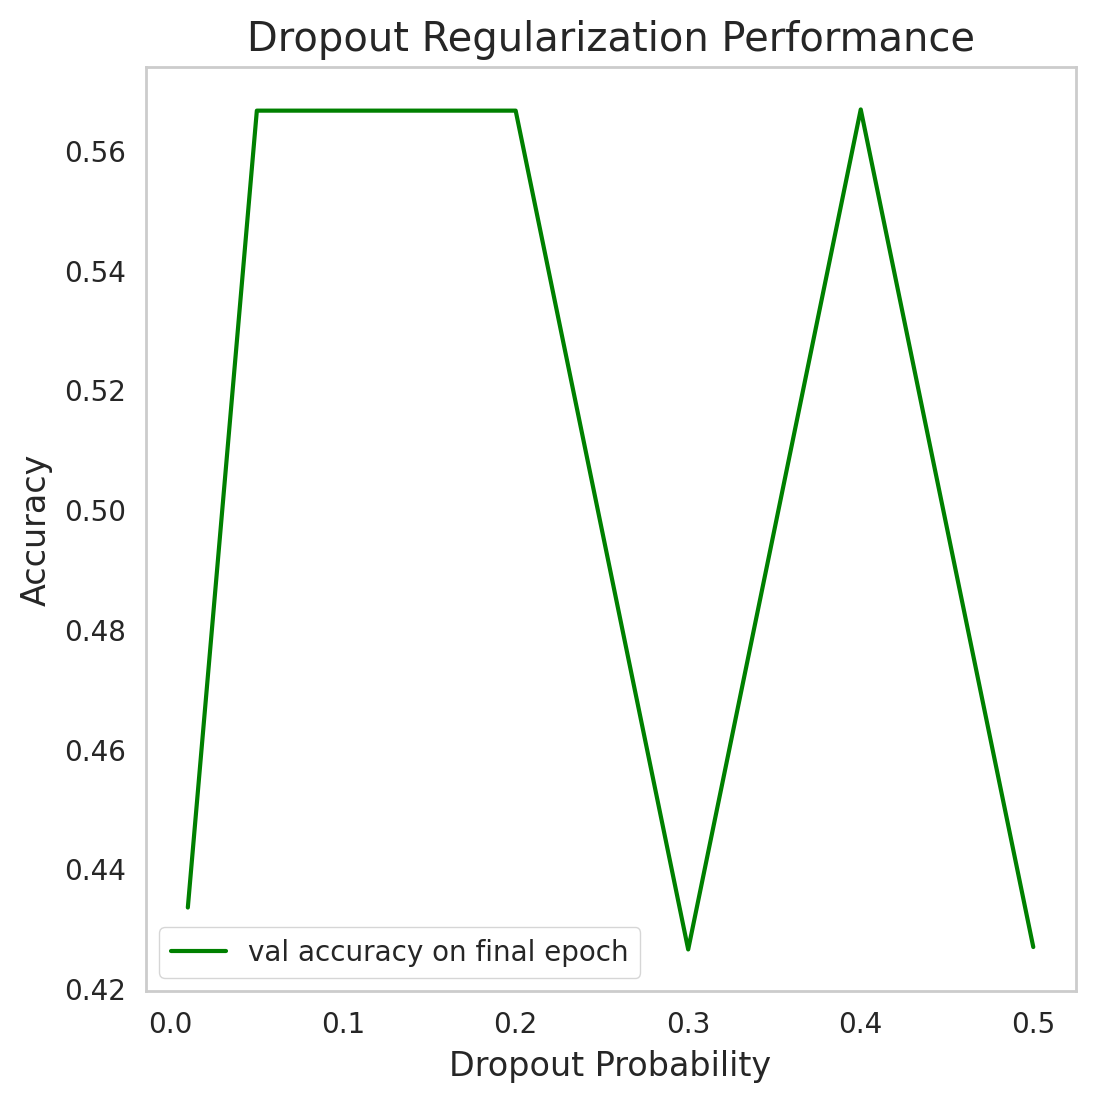

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

#plot for the regularized model - adding dropout layers
dropout_prob_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
final_valid_accuracy = [.4336, .5667, .5667, .5667, .4266 ,.5669, .4270]

plt.plot(dropout_prob_list, final_valid_accuracy, color='green', label='val accuracy on final epoch')
plt.legend()
plt.title("Dropout Regularization Performance")
plt.xlabel('Dropout Probability')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
test_dataset = datasets.ImageFolder(os.path.join('/content/test'), transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=4)

In [ ]:
model_dropouts.eval()
test_acc = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()
        test_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()
test_acc /= len(test_dataset)

print(f'Test Acc: {test_acc:.4f}')

# Regularization: Model Including L2 Regularization

In [ ]:
import torch.nn.functional as F

class MyRegModel(nn.Module):
    def __init__(self, alpha=0.01, device='cpu'):
        super(MyRegModel, self).__init__()
        self.alpha = alpha
        self.device = device
        self.regmodel = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Flatten(),
            nn.Linear(128 * 9 * 9, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
      return self.regmodel(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regmodel = MyRegModel(device=device)
regmodel.to(device)

In [ ]:
# Set the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=1)
#test values between .00005 to .0005; 1e-4 - 1e-5 test these values of weight decay for L2 reg
#test values of learning rate in the same range: 1e-3 - 1e-5

# Data preprocessing and normalization
data_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the datasets
train_dataset = datasets.ImageFolder(os.path.join('/content/train'), transform=data_transforms)
validation_dataset = datasets.ImageFolder(os.path.join('/content/validation'), transform=data_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False, num_workers=4)

# Training loop
num_epochs = 10
regmodel = MyRegModel()

alpha_l1 = 1e-5
alpha_l2 = 1e-5

train_acc_values = []
val_acc_values = []
train_loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
    model_dropouts.train()
    train_loss = 0.0
    train_acc = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        #print(inputs.size())
        optimizer.zero_grad()

        outputs = model_dropouts(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_dataset)

    regmodel.eval()
    validation_loss = 0.0
    validation_acc = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = regmodel(inputs).squeeze()
            loss = criterion(outputs, labels.float())

            validation_loss += loss.item()
            validation_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()

    validation_loss /= len(validation_loader)
    validation_acc /= len(validation_dataset)

    train_acc_values.append(train_acc)
    val_acc_values.append(validation_acc)
    train_loss_values.append(train_loss)
    val_loss_values.append(validation_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}')
    print(f'Validation Loss: {validation_loss:.4f}  Validation Acc: {validation_acc:.4f}')

# Data Augmentation: Model Including Transformations and Augmented Data

In [25]:
import torch
from torch import nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Flatten(),
            nn.Linear(128 * 9 * 9, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

model = MyModel()

In [26]:
# Create the model
model = MyModel()

# Set the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations to apply to the training data
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((150, 150)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomPerspective(distortion_scale = 0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#define transformations to apply to the validation data
val_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = datasets.ImageFolder(os.path.join('/content/train'), transform=train_transforms)
validation_dataset = datasets.ImageFolder(os.path.join('/content/validation'), transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False, num_workers=4)

# Training loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_acc_values = []
val_acc_values = []
train_loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        #print(inputs.size())
        optimizer.zero_grad()

        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_dataset)

    model.eval()
    validation_loss = 0.0
    validation_acc = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())

            validation_loss += loss.item()
            validation_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()

    validation_loss /= len(validation_loader)
    validation_acc /= len(validation_dataset)

    train_acc_values.append(train_acc)
    val_acc_values.append(validation_acc)
    train_loss_values.append(train_loss)
    val_loss_values.append(validation_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}')
    print(f'Validation Loss: {validation_loss:.4f}  Validation Acc: {validation_acc:.4f}')

Epoch 1/10
Train Loss: 0.4596  Train Acc: 0.7861
Validation Loss: 0.3527  Validation Acc: 0.8558
Epoch 2/10
Train Loss: 0.3841  Train Acc: 0.8321
Validation Loss: 0.3230  Validation Acc: 0.8728
Epoch 3/10
Train Loss: 0.3627  Train Acc: 0.8451
Validation Loss: 0.3036  Validation Acc: 0.8743
Epoch 4/10
Train Loss: 0.3504  Train Acc: 0.8507
Validation Loss: 0.3108  Validation Acc: 0.8796
Epoch 5/10
Train Loss: 0.3384  Train Acc: 0.8555
Validation Loss: 0.3180  Validation Acc: 0.8560
Epoch 6/10
Train Loss: 0.3257  Train Acc: 0.8591
Validation Loss: 0.2641  Validation Acc: 0.8960
Epoch 7/10
Train Loss: 0.3151  Train Acc: 0.8662
Validation Loss: 0.2704  Validation Acc: 0.8886
Epoch 8/10
Train Loss: 0.3084  Train Acc: 0.8674
Validation Loss: 0.2454  Validation Acc: 0.8966
Epoch 9/10
Train Loss: 0.3060  Train Acc: 0.8680
Validation Loss: 0.3476  Validation Acc: 0.8546
Epoch 10/10
Train Loss: 0.2913  Train Acc: 0.8756
Validation Loss: 0.3358  Validation Acc: 0.8884


In [29]:
test_dataset = datasets.ImageFolder(os.path.join('/content/test'), transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=4)

In [30]:
model.eval()
test_acc = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()
        test_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()
test_acc /= len(test_dataset)

print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.5952


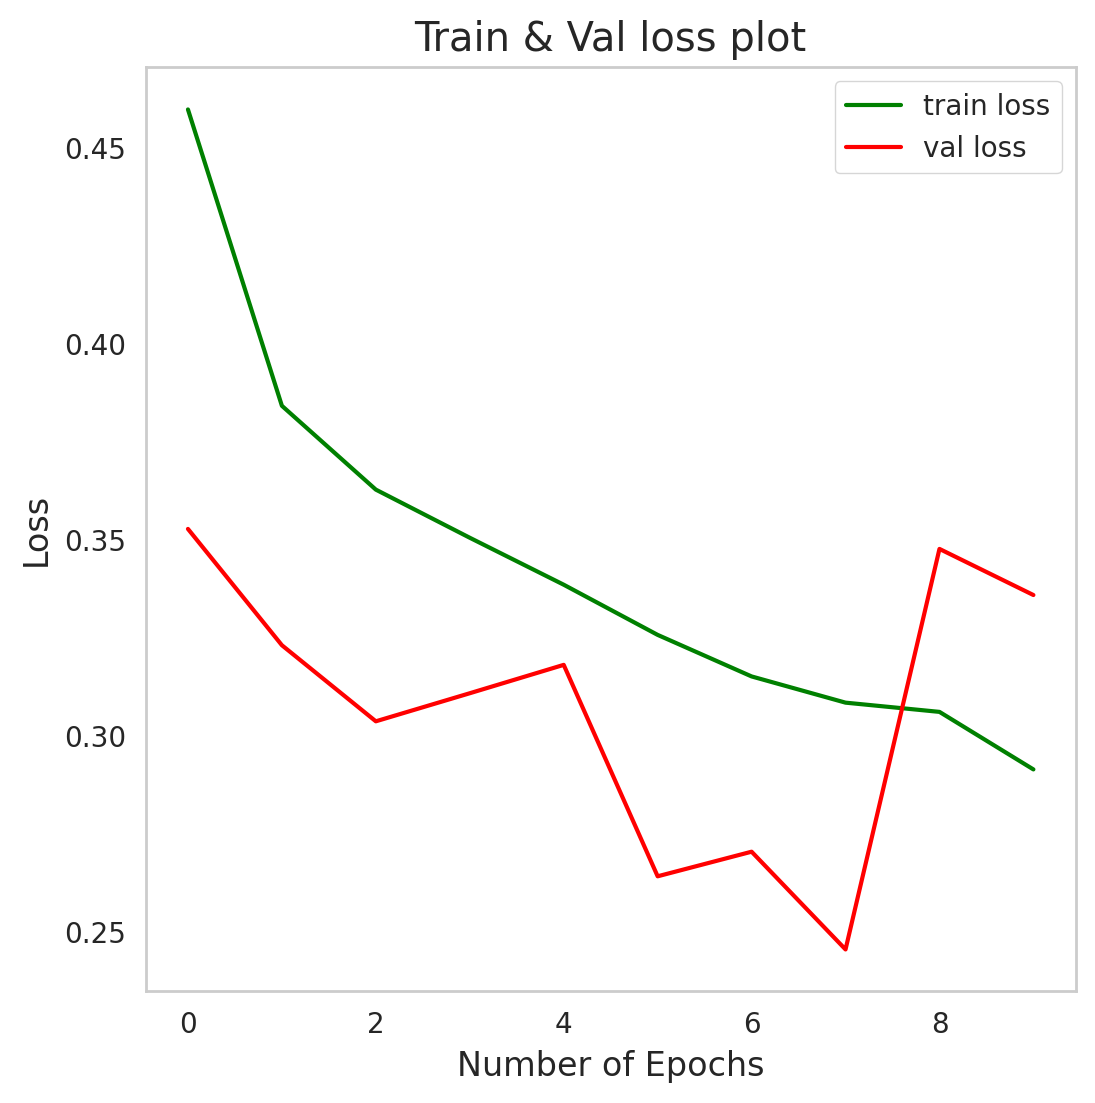

In [31]:
#Loss plot for model with random transformations
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss_values)), train_loss_values, color='green', label='train loss')
plt.plot(range(len(val_loss_values)), val_loss_values, color='red', label='val loss')
plt.legend()
plt.title("Train & Val loss plot")
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

plt.show()

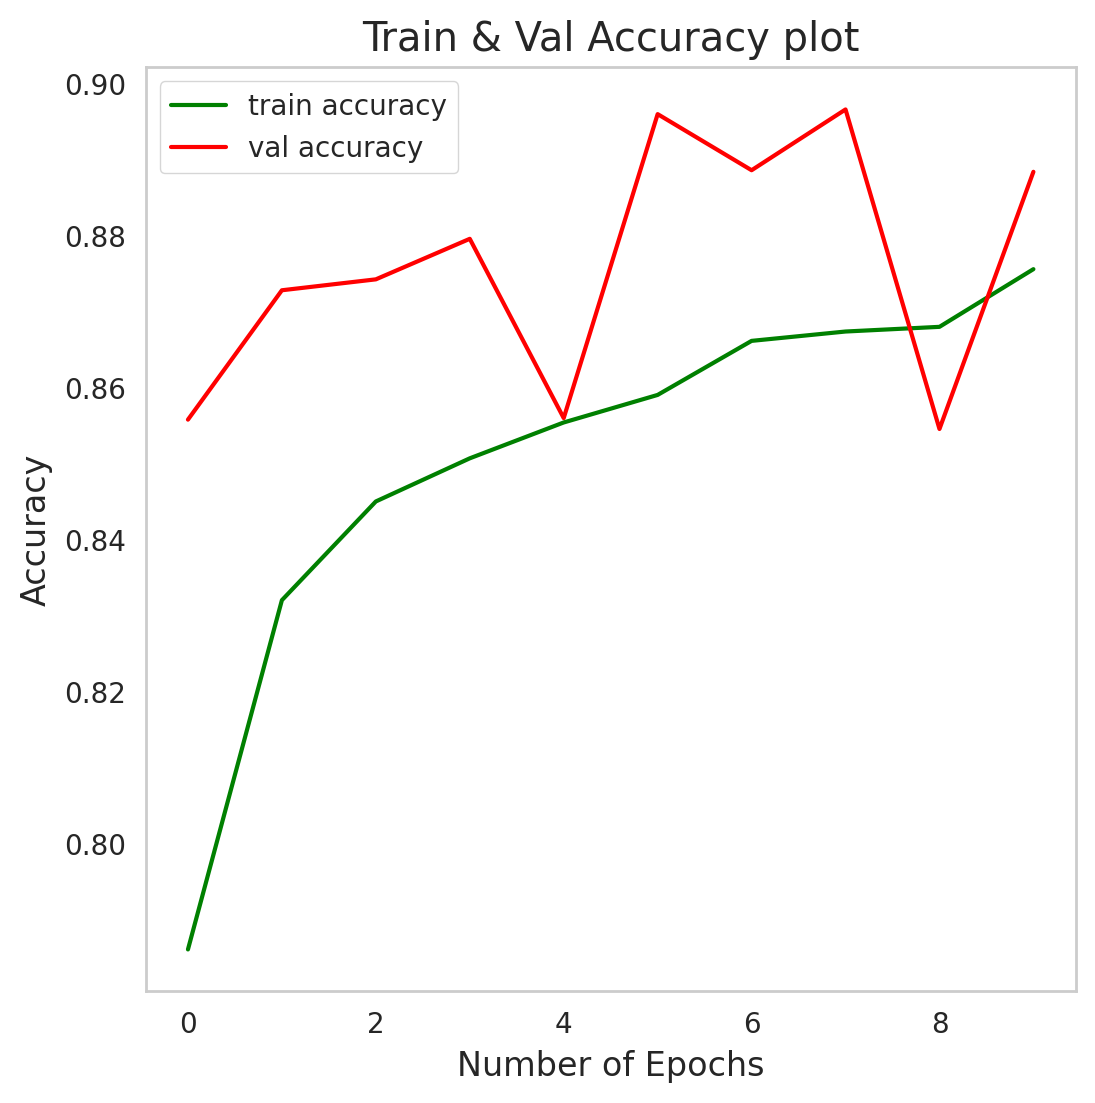

In [32]:
#Accuracy plot for model with random transformations
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_acc_values)), train_acc_values, color='green', label='train accuracy')
plt.plot(range(len(val_acc_values)), val_acc_values, color='red', label='val accuracy')
plt.legend()
plt.title("Train & Val Accuracy plot")
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

plt.show()

# K-Means Clustering for Image Compression:  Test on One Image

In [ ]:
from skimage import io
from sklearn.cluster import KMeans
import numpy as np

#Read the image
image_og = io.imread('/content/train/damage/10002.jpeg')
io.imshow(image_og)
io.show()

In [ ]:
#Dimension of the original image
rows = image_og.shape[0]
cols = image_og.shape[1]

In [ ]:
#Flatten the image
image = image_og.reshape(rows*cols, 3)

In [ ]:
#Implement k-means clustering to form k clusters
kmeans = KMeans(n_clusters=10)
kmeans.fit(image)

#Replace each pixel value with its nearby centroid
compressed_image = kmeans.cluster_centers_[kmeans.labels_]
compressed_image = np.clip(compressed_image.astype('uint8'), 0, 255)

#Reshape the image to original dimension
compressed_image = compressed_image.reshape(rows, cols, 3)

In [ ]:
#Save and display output image
io.imsave('compressed_image_10.png', compressed_image)
io.imshow(compressed_image)
io.show()

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Display the original image in the left subplot
axes[0].imshow(image_og)
axes[0].set_title('Original Image')

# Display the compressed image in the right subplot
axes[1].imshow(compressed_image)
axes[1].set_title('After K-Means Clustering for Image Compression')

# Show the figure
plt.show()

In [ ]:
print(type(compressed_image))

#K-Means Clustering for Image Compression: Implement on Entire Training Dataset

In [ ]:
#new directory to store the compressed images
os.makedirs("/content/compressed_train/damage", exist_ok=True)
os.makedirs("/content/compressed_train/no_damage", exist_ok=True)

In [ ]:
compressed_train_damage = original_dataset_dir + '/compressed_train/damage'
compressed_train_nodamage = original_dataset_dir + '/compressed_train/no_damage'

In [ ]:
# set the number of clusters
num_clusters = 10

In [ ]:
#train_damage_dir
#train_nodamage_dir

In [ ]:
# loop over the damage images
for img_file in os.listdir(train_damage_dir):
    # load the image
    img_path = os.path.join(train_damage_dir, img_file)
    img = Image.open(img_path)
    
    # convert the image to a numpy array and flatten it
    img_arr = np.array(img)
    rows, cols, _ = img_arr.shape
    img_arr = img_arr.reshape(rows*cols, 3)
    
    # perform k-means clustering and replace pixel values with nearby centroids
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(img_arr)
    compressed_img = kmeans.cluster_centers_[kmeans.labels_]
    compressed_img = np.clip(compressed_img.astype('uint8'), 0, 255)
    
    # reshape the compressed image to its original dimensions and save to disk
    compressed_img = compressed_img.reshape(rows, cols, 3)
    compressed_img = Image.fromarray(compressed_img)
    compressed_path = os.path.join(compressed_train_damage, img_file)
    compressed_img.save(compressed_path)

#loop over the no_damage images
for img_file in os.listdir(train_nodamage_dir):
    # load the image
    img_path = os.path.join(train_nodamage_dir, img_file)
    img = Image.open(img_path)
    
    # convert the image to a numpy array and flatten it
    img_arr = np.array(img)
    rows, cols, _ = img_arr.shape
    img_arr = img_arr.reshape(rows*cols, 3)
    
    # perform k-means clustering and replace pixel values with nearby centroids
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(img_arr)
    compressed_img = kmeans.cluster_centers_[kmeans.labels_]
    compressed_img = np.clip(compressed_img.astype('uint8'), 0, 255)
    
    # reshape the compressed image to its original dimensions and save to disk
    compressed_img = compressed_img.reshape(rows, cols, 3)
    compressed_img = Image.fromarray(compressed_img)
    compressed_path = os.path.join(compressed_train_nodamage, img_file)
    compressed_img.save(compressed_path)

In [ ]:
#typing something then ignoring it
#my bullshit box
#look google colab the nb is still active
#bl bl bla
#writing something to make runtime not disconnect
#dont' do that
#let's test this

In [ ]:
print('total compressed training damage images: ',len(os.listdir(compressed_train_damage)))